Data acquisition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx

def read_graph(filename):
    #Reads the graph itself.

    type_ids = ["lut", "ff", "i"]

    g = open(filename, "r")
    lines = g.readlines()
    g.close()

    G = nx.DiGraph()
    cnt = 1
    for line in lines[1:]:
        words = line.split()
        node_type = type_ids[int(words[0])]
        outdeg = int(words[1])
        G.add_node(cnt, node_type = node_type)
        if outdeg:
            for w in words[2:]:
                G.add_edge(cnt, int(w))
        cnt += 1

    return G

In [2]:
graph_path = "data/apex6.circ"
G = read_graph(graph_path)

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, spectral_embedding

Dimensionality reduction techniques embed high dimentional data points into lower dimensional spaces while preserving as much of the initial connectivity as possible. However, the input data sets of this project consist of nodes in a graph rather than high dimensional data points, which limit the options for dimensionality reduction to spectral embedding alone.

In order to evaluate other techniques, we first use spectral embedding to map our nodes to high-dimensional (10-dimension) data points and then apply PCA, Isomap and t-SNE to map those points to a 2- or 3-dimensional space where visual inspection is easy. We compare those results to those produced by using spectral embedding to map nodes to a 2-dimensional space directly.

In [4]:
G_spectral = spectral_embedding(nx.adjacency_matrix(G), n_components=10)
G_spectral_2 = spectral_embedding(nx.adjacency_matrix(G), n_components=2)

/home/asiatici/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/utils/validation.py:855: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
/home/asiatici/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/utils/validation.py:855: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


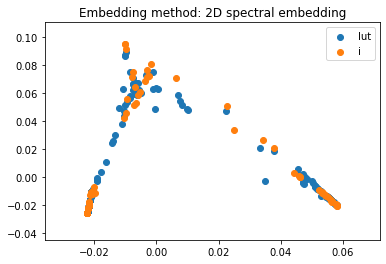

In [5]:
type_to_number = {'lut': 0, 'i': 1}

node_types = [x[1]['node_type'] for x in G.nodes(data=True)]
node_types_num = [type_to_number[x] for x in node_types]
for i in type_to_number:
    mask = np.array(node_types) == i
    plt.scatter(G_spectral_2[mask, 0], G_spectral_2[mask, 1], label=i)
plt.title('Embedding method: 2D spectral embedding')
plt.legend();

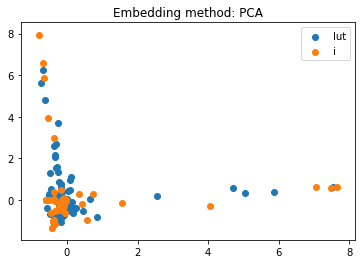

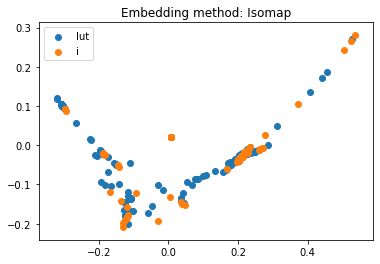

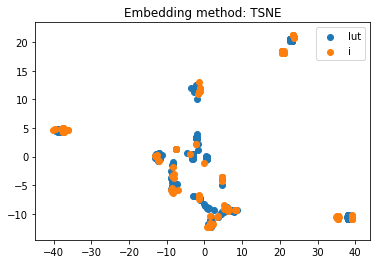

In [6]:
embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]
all_embeddings_2d = []
for embedding in embeddings:
    X_embedded = embedding.fit_transform(G_spectral)
    fig = plt.figure()
    for i in type_to_number:
        mask = np.array(node_types) == i
        plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
    #scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=node_types_num, label=['lut', 'i'])
    #plt.legend(*scatter.legend_elements())
    plt.legend()
    plt.title('Embedding method: '+ type(embedding).__name__)
    plt.show()
    all_embeddings_2d.append(X_embedded)

2D t-SNE provides the most clearly distinguishable clusters for all the circuits we tested. Below, we include the 3D versions of the same embedding techniques for completeness, even though they do not seem to provide a higher quality of results, at least upon visual inspection.

No handles with labels found to put in legend.


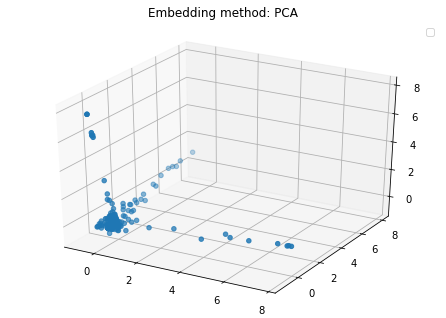

No handles with labels found to put in legend.


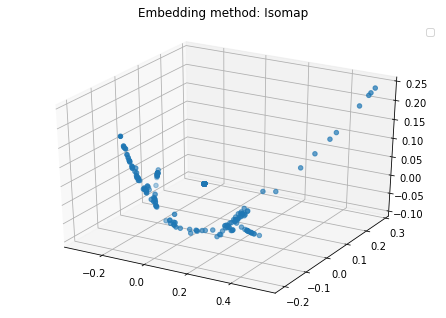

No handles with labels found to put in legend.


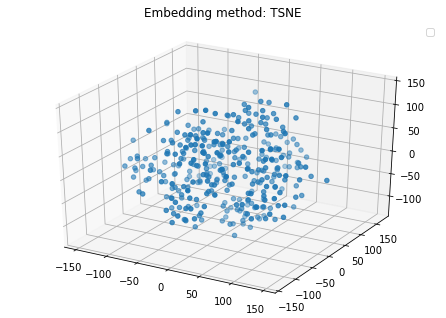

In [7]:
from mpl_toolkits.mplot3d import Axes3D
all_embeddings_3d = []
embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
              Isomap(n_components=3, n_neighbors=5),
              TSNE(n_components=3)]

for embedding in embeddings:
    X_embedded = embedding.fit_transform(G_spectral)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2])
    ax.legend()
    ax.title.set_text('Embedding method: '+ type(embedding).__name__)
    plt.show()
    all_embeddings_3d.append(X_embedded)

As a first step to evaluate whether the clusters identified by 2D t-SNE correspond to clusters in the VPR placement result (which can also be seen as a 2D-embedding subject to extra constraints), we tested some clustering techniques on the output of 2D t-SNE.

KMeans is a first simple solution; however, the number of clusters has to be set manually for each circuit and, because most of the "intuitive" clusters are not Gaussian in shape, KMeans rarely identifies them correctly. In practice, KMeans achieved acceptable results only on *apex6* where clusters are very well separated from each other.

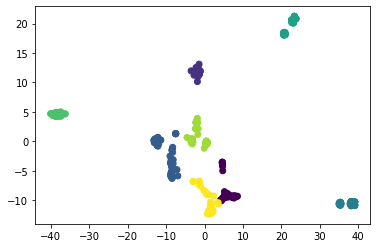

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(all_embeddings_2d[2])
y_pred = kmeans.labels_
plt.scatter(all_embeddings_2d[2][:, 0], all_embeddings_2d[2][:, 1], c=y_pred)
plt.show()

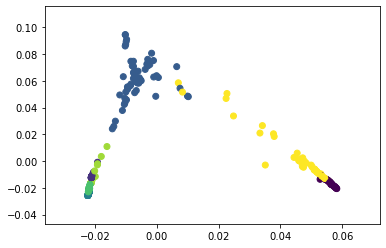

In [9]:
plt.scatter(G_spectral_2[:, 0], G_spectral_2[:, 1], c=y_pred)
plt.show()

We now write the cluster information back to file for further analysis in `main.ipynb`.

In [10]:
nodes_labels = [(x, y) for x, y in zip([x for x in G.nodes()], y_pred)]
nodes_labels.sort(key=lambda x: x[0])

with open(graph_path + '.knn', 'w') as f, open(graph_path, 'r') as f_in:
    f.write(f_in.readline())
    for row, label in zip(f_in, nodes_labels):
        f.write("{} {}".format(label[1], row))